In [1]:
# only run this if you have not cloned it or you need to fetch the latest commits
! if [ -d cytounet ]; then pushd cytounet && git fetch origin && git reset --hard origin/master && git clean -fd && popd; else git clone https://github.com/Nelson-Gon/cytounet.git; fi

/content/cytounet /content
HEAD is now at 255875e Add image sampler
/content


In [2]:
%cd cytounet 

/content/cytounet


In [3]:
from cytounet.model import *
from cytounet.augmentation import *
from cytounet.data import *
from cytounet.post_model import *


In [7]:
# threshold chosen based on histogram and visual view in Fiji
# same procedure for the validation data set
# thresholded = threshold_images("examples/original_data/a549/train/fluorescent_masks",thresh_val=83)

In [15]:
x_train = read_images("examples/original_data/a549/train/images")
y_train = read_images("examples/original_data/a549/train/masks")
x_test = read_images("test/images")

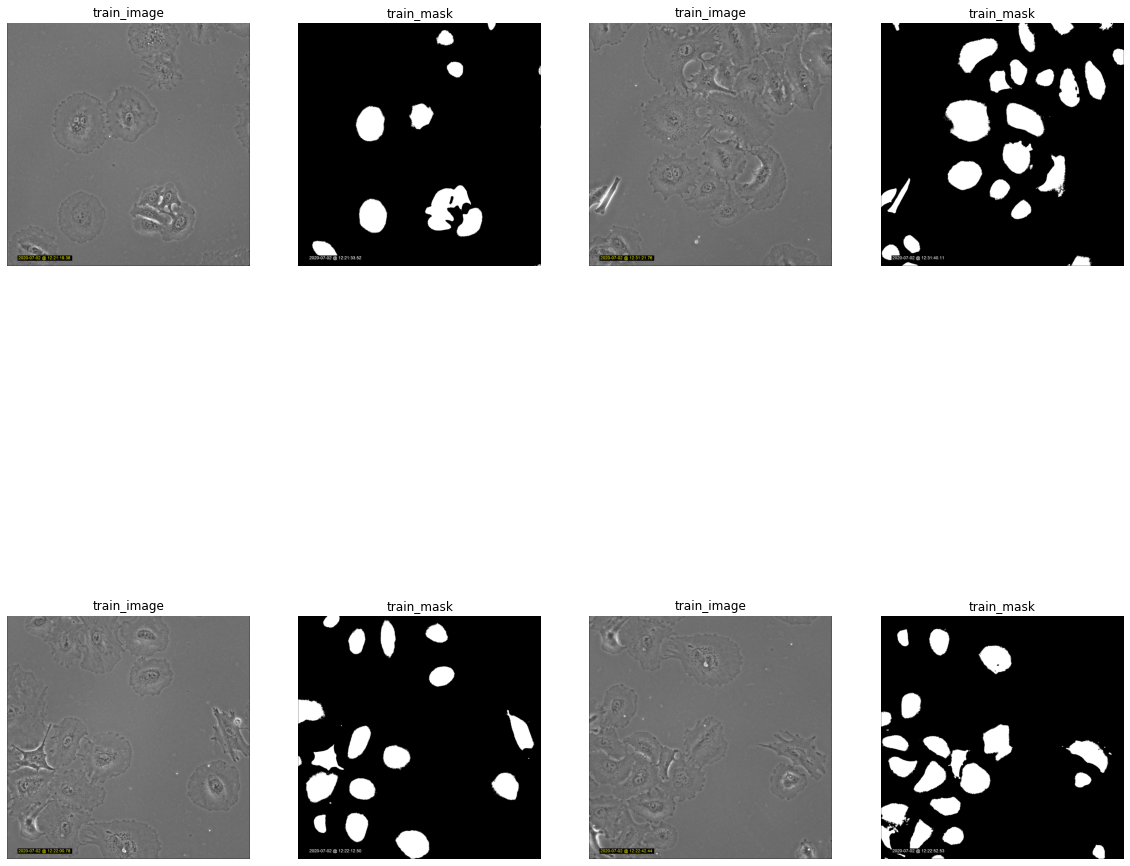

In [5]:
show_images(x_train, y_train, number =4, titles = ['train_image', 'train_mask'])

In [6]:
data_generator_args =  dict(rotation_range=0.1,
                      rescale = 1./255,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [7]:
%cd examples/original_data/a549/

/content/cytounet/examples/original_data/a549


In [8]:
my_generator = generate_train_data(8,'train', 'images','masks',data_generator_args,save_to_dir =None, seed= 2,target_size = (512, 512))


In [9]:
valid_generator = generate_validation_data(8, "validation", "images", "masks", data_generator_args, save_to_dir=None, seed=12,
                                           target_size = (512, 512))

In [10]:
model = unet(learning_rate=1e-4, input_size=(512, 512, 1), metrics =dice_coef, loss=dice_coef_loss,
             use_regularizer = False)

In [12]:
history = train(model_object=model, train_generator=my_generator, epochs = 10, steps_per_epoch= 120 , batch_size = 8)

Epoch 1/10
120/120 [==============================] - 59s 488ms/step - loss: 0.0873 - dice_coef: 0.9113
Epoch 2/10
120/120 [==============================] - 58s 486ms/step - loss: 0.0795 - dice_coef: 0.9195
Epoch 3/10
120/120 [==============================] - 58s 484ms/step - loss: 0.0737 - dice_coef: 0.9258
Epoch 4/10
120/120 [==============================] - 57s 477ms/step - loss: 0.0701 - dice_coef: 0.9286
Epoch 5/10
120/120 [==============================] - 57s 478ms/step - loss: 0.0647 - dice_coef: 0.9341
Epoch 6/10
120/120 [==============================] - 58s 481ms/step - loss: 0.0628 - dice_coef: 0.9361
Epoch 7/10
120/120 [==============================] - 57s 476ms/step - loss: 0.0602 - dice_coef: 0.9392
Epoch 8/10
120/120 [==============================] - 57s 477ms/step - loss: 0.0577 - dice_coef: 0.9415
Epoch 9/10
120/120 [==============================] - 57s 475ms/step - loss: 0.0557 - dice_coef: 0.9439
Epoch 10/10
120/120 [==============================] - 56s 470ms

In [13]:
model.save("a549_scratch_github.hdf5")

In [14]:
results = predict(test_path="test",model_weights= "a549_scratch_github.hdf5",train_seed = 12,custom_loss = {'dice_coef': dice_coef,
                                               'dice_coef_loss': dice_coef_loss}, target_size = (512, 512))

Found 10 images belonging to 1 classes.
['images/img_1.tif', 'images/img_10.tif', 'images/img_2.tif', 'images/img_3.tif', 'images/img_4.tif', 'images/img_5.tif', 'images/img_6.tif', 'images/img_7.tif', 'images/img_8.tif', 'images/img_9.tif']


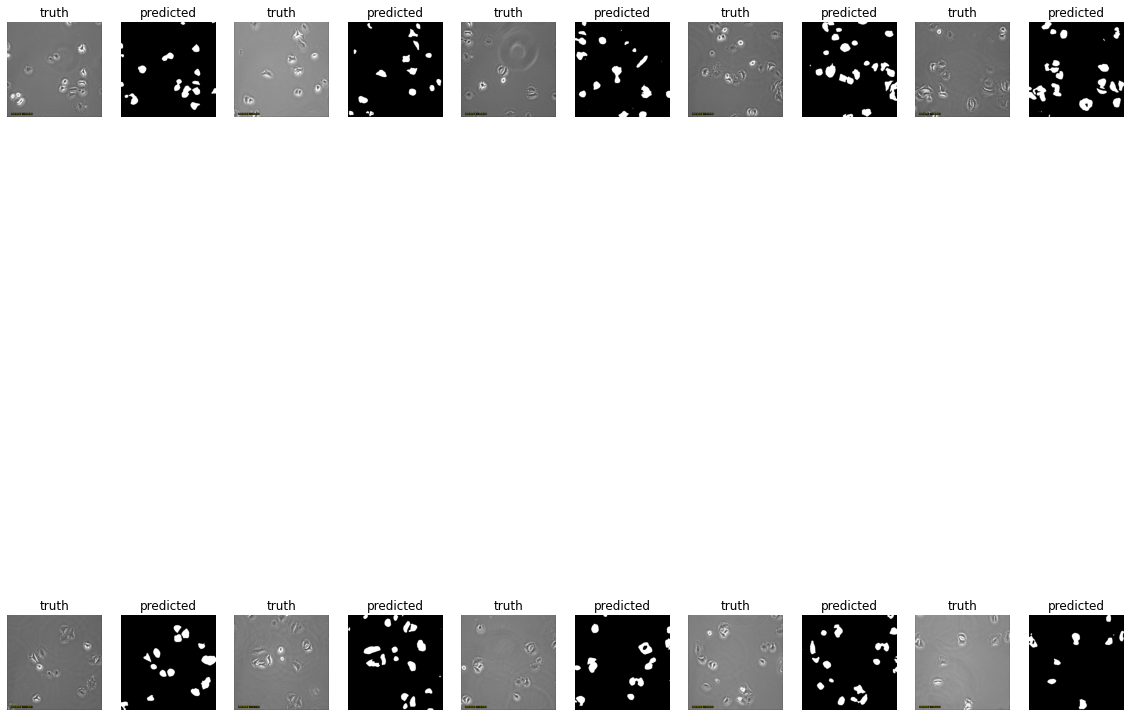

In [16]:
show_images(x_test, results,number = 10, titles=['truth', 'predicted'], figure_size=(20,20))

In [17]:
# when training from scratch, provide both x and y. Otherwise, provide a generator eg my_generator
finetuned = finetune(pretrained_weights="a549_scratch_github.hdf5",
                   model_object=model, train_generator=my_generator, epochs = 5, steps_per_epoch= 100 , batch_size = 8,
                verbose=1,   validation_data=valid_generator, 
                 validation_steps = 20, monitor_metric='val_loss')

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.0529 - dice_coef: 0.9462Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
['images/img_1.tif', 'images/img_10.tif', 'images/img_2.tif', 'images/img_3.tif', 'images/img_4.tif', 'images/img_5.tif', 'images/img_6.tif', 'images/img_7.tif', 'images/img_8.tif', 'images/img_9.tif']
['masks/msk_1.tif', 'masks/msk_10.tif', 'masks/msk_2.tif', 'masks/msk_3.tif', 'masks/msk_4.tif', 'masks/msk_5.tif', 'masks/msk_6.tif', 'masks/msk_7.tif', 'masks/msk_8.tif', 'masks/msk_9.tif']

Epoch 00001: val_loss improved from inf to 0.41184, saving model to a549_scratch_github.hdf5
100/100 [==============================] - 61s 613ms/step - loss: 0.0529 - dice_coef: 0.9462 - val_loss: 0.4118 - val_dice_coef: 0.6245
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.0517 - dice_coef: 0.9473
Epoch 00002: val_loss did not improve from 0.41184
100/100 [==============================] - 59s 589ms/s

In [18]:
results_fine_tuned = predict(test_path="test",model_weights= "a549_scratch_github.hdf5",train_seed = 12,custom_loss = {'dice_coef': dice_coef,
                                               'dice_coef_loss': dice_coef_loss}, target_size = (512, 512))

Found 10 images belonging to 1 classes.
['images/img_1.tif', 'images/img_10.tif', 'images/img_2.tif', 'images/img_3.tif', 'images/img_4.tif', 'images/img_5.tif', 'images/img_6.tif', 'images/img_7.tif', 'images/img_8.tif', 'images/img_9.tif']


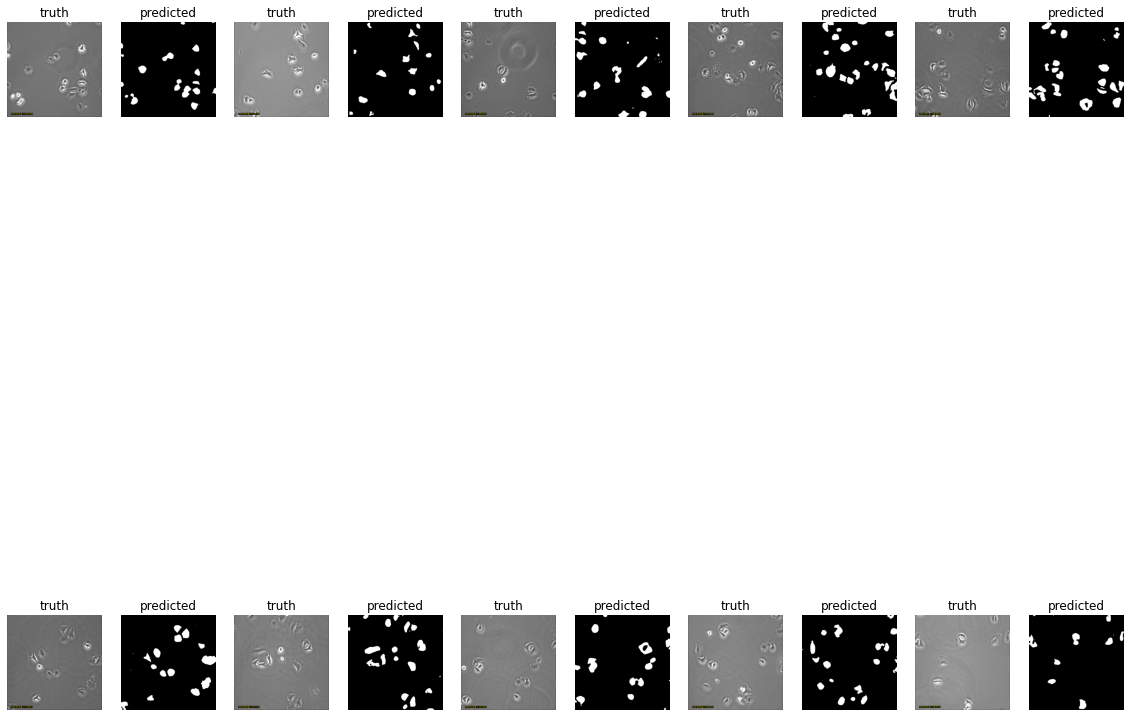

In [19]:
show_images(x_test, results_fine_tuned,number = 10, titles=['truth', 'predicted'], figure_size=(20,20))

In [20]:

res_resized = resize_images(results_fine_tuned, (1200, 1200,1))

In [21]:
!mkdir predictions

In [ ]:
save_predictions("predictions", res_resized, image_prefix="prediction_sample_",image_suffix="tif")